# Modelos Descritivos - Projeto Final
### Residência de Ciência de Dados - CIN/UFPE

- Lucas Couri (lncc2)
- Mariama Oliveira (mcso)

# Estudo sobre geração de áudio utilizando VAE
## 1. Objetivo

O objetivo do projeto é a geração de música a partir do uso de um Variational AutoEnconder, para tal partiu-se de um modelo utilizado para geração de fala.

Portanto, o projeto seguiu duas etapas:

1. Gerar áudio de dígitos aleatórios a partir do dataset de áudio de dígitos MNIST (https://www.kaggle.com/alanchn31/free-spoken-digits), utilizamos 3000 arquivos de áudio para o experimento.

2. Verificar se a mesma metodologia pode ser aplicada para músicas, de forma a gerar composições musicais com base em músicas de determinado gênero musical disponíveis no dataset GTZAN (https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification).

Ao final, deseja-se entender como VAE pode ser utilizado na geração de amostras de audio.

## 2. Metodologia

Nesta seção serão descritos a base de dados e os passos e métodos utilizados para a realização do projeto.

Este projeto tem como base o tutorial do YouTube do **Valerio Velardo - The Sound of AI**. Para mais informações acessar: https://www.youtube.com/watch?v=Ey8IZQl_lKs&list=PL-wATfeyAMNpEyENTc-tVH5tfLGKtSWPp


### 2.1 Descrição das bases de dados

**Base áudio de dígitos MNIST**

Base que contém o resgistro em .wav dos dígitos de 0 a 9 de 
- 6 falantes
- 3,000 áudios (50 por cada falante)
- Pronúncia em inglês 

**Base áudio GTZAN**

Base que contém o resgistro em .wav de músicas
- 10 gêneros musicais (cada gênero 100 músicas)
- 30 segundos

### 2.2 Descrição do experimento

Foram realizados os seguintes passos:

1. Pré-processamento de dados

2. Treinamento do modelo (VAE) -> O código do VAE se encontra no script autoencoder.py

3. Geração da amostra a partir do espaço latente obtido no passo 2.

#### Bibliotecas e dados

In [8]:
import autoencoder as ae
import train as tr
import preprocess as pp
import soundgenerator as sg
import generate as gn

from soundgenerator import SoundGenerator
from autoencoder import VAE
import pickle
import IPython.display as ipd

import matplotlib.pyplot as plt

import librosa
import librosa.display
import numpy as np

### 2.2.1 Pré-processamento do dados

O pipeline de pré-processamento consiste em 5 passos:

1. Carregar arquivos .wav (waveplot)

2. Aplicar padding caso seja necessário (quando a duração do arquivo é menor que a padrão)

3. Extrair espectrogramas

4. Normalizar os dados com MinMax

5. Salvar os espectrogramas e os valores de MinMax para cada espectrograma.

O código do pré-processamento está no script **preprocess.py**

#### Executando pipeline de pré-processamento

Devido às características distintas da fala e música, a amostragem no carregamento de cada áudio é diferente, portanto abaixo são determinados os parâmetros para cada tipo de áudio.

**Vale notar que, a fim de organização, o código relativo a geração de composições musicais se encontra comentado. Caso queira rodar o código, basta descomentar os parâmetros.

In [25]:
#Parametros de amostragem do audio
FRAME_SIZE = 512
HOP_LENGTH = 256
DURATION = 0.74  # em segundos
SAMPLE_RATE = 22050
MONO = True

#Path dos dados
SPECTROGRAMS_PATH = "data/fsdd/spectrograms/"
MIN_MAX_VALUES_SAVE_DIR = "data/fsdd/"
FILES_DIR = "data/recordings/"

In [ ]:
# #Parametros de amostragem de música (jazz)
# FRAME_SIZE = 1024
# HOP_LENGTH = 512
# DURATION = 5.94  # em segundos
# SAMPLE_RATE = 22050
# MONO = True

# #Path dos dados
# SPECTROGRAMS_PATH = "data/fsdd-jazz/spectrograms/"
# MIN_MAX_VALUES_SAVE_DIR = "data/fsdd-jazz/"
# FILES_DIR = "data/jazz/"

In [ ]:
# #Parametros de amostragem de música (metal)
# FRAME_SIZE = 1024
# HOP_LENGTH = 512
# DURATION = 5.94  # em segundos
# SAMPLE_RATE = 22050
# MONO = True

# #Path dos dados
# SPECTROGRAMS_PATH = "data/fsdd-metal/spectrograms/"
# MIN_MAX_VALUES_SAVE_DIR = "data/fsdd-metal/"
# FILES_DIR = "data/metal/"

In [ ]:
# Instanciando objetos 
loader = pp.Loader(SAMPLE_RATE, DURATION, MONO)
padder = pp.Padder()
log_spectrogram_extractor = pp.LogSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH)
min_max_normaliser = pp.MinMaxNormaliser(0, 1)
saver = pp.Saver(SPECTROGRAMS_PATH, MIN_MAX_VALUES_SAVE_DIR)

preprocessing_pipeline = pp.PreprocessingPipeline()
preprocessing_pipeline.loader = loader
preprocessing_pipeline.padder = padder
preprocessing_pipeline.extractor = log_spectrogram_extractor
preprocessing_pipeline.normaliser = min_max_normaliser
preprocessing_pipeline.saver = saver

preprocessing_pipeline.process(FILES_DIR)

Exemplo de waveplot (audio raw) e espectrograma (audio processado) gerado após pré-processamento

Exemplo digits

Text(0.5, 1.0, 'Waveplot do 0_george_0.wav')

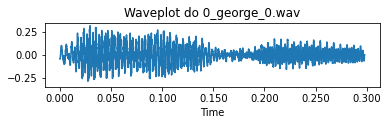

In [9]:
y, sr = librosa.load('data/recordings/0_george_0.wav', duration= 0.5)
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Waveplot do 0_george_0.wav')

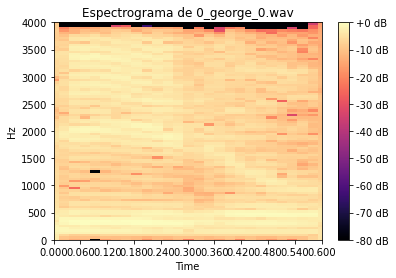

In [18]:
spectrogram = np.load("data/fsdd/spectrograms/0_george_0.wav.npy")
S_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Espectrograma de 0_george_0.wav', xlim=(0, 0.6), ylim=(0, 4000))
fig.colorbar(img, ax=ax, format="%+2.f dB")

Exemplo música

Text(0.5, 1.0, 'Waveplot do jazz.00001.wav')

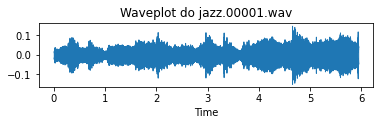

In [10]:
y, sr = librosa.load('data/jazz/jazz.00001.wav', duration= 5.94)
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Waveplot do jazz.00001.wav')

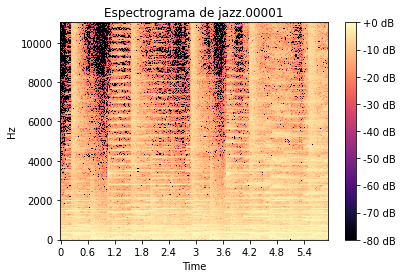

In [11]:
spectrogram = np.load("data/fsdd-jazz/spectrograms/jazz.00001.wav.npy")
S_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Espectrograma de jazz.00001')
fig.colorbar(img, ax=ax, format="%+2.f dB")

### 2.2.2 Variational AutoEncoder

A arquitetura do Variational Autoencoder é composta por 5 camadas convolucionais, sendo cada uma composta por uma conv 2d, uma camada ReLU e uma camada de batch normalization. No meio do encoder/decoder há também uma camada densa onde é feito o cálculo do espaço latente.

#### Treinando Modelo

O modelo foi treinado a partir dos espectogramas extraídos anteriormente, eles tem tamanho 256x64.

In [ ]:
# Parâmetros para áudios de dígitos
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
EPOCHS = 150
DIR_MODEL = "model/digits/"

In [ ]:
# # Parâmetros para músicas (jazz)
# LEARNING_RATE =  0.0005
# BATCH_SIZE = 1
# EPOCHS = 6
# DIR_MODEL = "model/jazz/"

In [ ]:
# # Parâmetros para músicas (metal)
# LEARNING_RATE =  0.0005
# BATCH_SIZE = 1
# EPOCHS = 6
# DIR_MODEL = "model/metal/"

In [ ]:
x_train = tr.load_fsdd(SPECTROGRAMS_PATH)
autoencoder = tr.train(x_train, LEARNING_RATE, BATCH_SIZE, EPOCHS, )
autoencoder.save(DIR_MODEL)

### 2.2.3 Reconstruindo amostra a partir Espaço Latente

Para gerar o áudio a partir do VAE, utilizamos algumas amostras de áudio, mapeamos no espaço latente e, por fim, reconstruímos a amostra.

Os dados foram salvos na pasta saples, a qual contém o dados originais e os reconstrídos.

In [ ]:
# Diretórios dos áudios dos dígitos
SAVE_DIR_ORIGINAL = "samples/digits/original/"
SAVE_DIR_GENERATED = "samples/digits/generated/"
MIN_MAX_VALUES_PATH = "data/fsdd/min_max_values.pkl"


In [ ]:
# Diretórios das músicas (jazz)
#SAVE_DIR_ORIGINAL = "samples/jazz/original/"
#SAVE_DIR_GENERATED = "samples/jazz/generated/"
#MIN_MAX_VALUES_PATH = "data/fsdd-jazz/min_max_values.pkl"


In [ ]:
# Diretórios das músicas (metal)
#SAVE_DIR_ORIGINAL = "samples/metal/original/"
#SAVE_DIR_GENERATED = "samples/metal/generated/"
#MIN_MAX_VALUES_PATH = "data/fsdd-metal/min_max_values.pkl"


In [ ]:
# Carregar modelo treinado
vae = VAE.load(DIR_MODEL)
sound_generator = SoundGenerator(vae, HOP_LENGTH)

# Carregar espectrograma + valores min max
with open(MIN_MAX_VALUES_PATH, "rb") as f:
    min_max_values = pickle.load(f)

specs, file_paths = gn.load_fsdd(SPECTROGRAMS_PATH)

# sample espectrograma + valores min max
sampled_specs, sampled_min_max_values = gn.select_spectrograms(specs,
                                                            file_paths,
                                                            min_max_values,
                                                            5)

# Gerar audio a partir do espaço latente
signals, _ = sound_generator.generate(sampled_specs,
                                        sampled_min_max_values)

# Convert espectrograma para arquivo de audio
original_signals = sound_generator.convert_spectrograms_to_audio(
    sampled_specs, sampled_min_max_values)

# Salva sinais de audio
gn.save_signals(signals, SAVE_DIR_GENERATED)
gn.save_signals(original_signals, SAVE_DIR_ORIGINAL)

## 3. Análise de resultados

Para executar os áudios é necessário rodar o notebook utilizando o Jupyter.

A seguir mostramos o waveform original e o reconstruído a título de comparação.

### Resultados dos áudios de dígitos

In [ ]:
### Audio original 1
audio1_orig = SAVE_DIR_ORIGINAL+"0.wav"
ipd.Audio(audio1_orig, rate=SAMPLE_RATE)

In [ ]:
### Audio gerado 1
audio1_gen = SAVE_DIR_GENERATED+"0.wav"
ipd.Audio(audio1_gen, rate=SAMPLE_RATE)

In [ ]:
### Audio original 2
audio2_orig = SAVE_DIR_ORIGINAL+"3.wav"
ipd.Audio(audio2_orig, rate=SAMPLE_RATE)

In [ ]:
### Audio gerado 2
audio2_gen = SAVE_DIR_GENERATED+"3.wav"
ipd.Audio(audio2_gen, rate=SAMPLE_RATE)

### Resultados das músicas

#### Jazz

In [ ]:
### Musica original 1
audio1_orig = "samples/jazz/original/0.wav"
ipd.Audio(audio1_orig, rate=SAMPLE_RATE)

In [ ]:
### Musica gerado 1
audio1_gen = "samples/jazz/generated/0.wav"
ipd.Audio(audio1_gen, rate=SAMPLE_RATE)

In [ ]:
### Musica original 2
audio2_orig = "samples/jazz/original/3.wav"
ipd.Audio(audio2_orig, rate=SAMPLE_RATE)

In [ ]:
### Musica gerado 2
audio2_gen = "samples/jazz/generated/3.wav"
ipd.Audio(audio2_gen, rate=SAMPLE_RATE)

#### Metal

In [ ]:
### Musica original 1
audio1_orig = "samples/metal/original/0.wav"
ipd.Audio(audio1_orig, rate=SAMPLE_RATE)

In [ ]:
### Musica gerado 1
audio1_gen = "samples/metal/generated/0.wav"
ipd.Audio(audio1_gen, rate=SAMPLE_RATE)

In [ ]:
### Musica original 2
audio2_orig = "samples/metal/original/3.wav"
ipd.Audio(audio2_orig, rate=SAMPLE_RATE)

In [ ]:
### Musica gerado 2
audio2_gen = "samples/metal/generated/3.wav"
ipd.Audio(audio2_gen, rate=SAMPLE_RATE)

# 4) Considerações finais

Comentários gerais:

- A arquitetura funcionou bem para o áudio dos dígitos, conseguindo reproduzir com poucas perdas o mesmo dígito. Já para as músicas notamos que não gerou áudios similares aos originais, isso pode ser devido a vários motivos. 

- Um palpite seria que talvez o uso de uma arquitetura recorrente forneça melhores resultados para este tipo de problema, uma vez que vários trabalhos e artigos da área utilizam redes recorrentes como solução.

- Outra possibilidade é a amostragem do pré-processamento, que tem uma quantidade limitada de amostras, já que música necessita de mais dados do que fala para representar informações. 

- Talvez seja melhor representar as músicas em outro tipo de codificação, mais compacta, como a midi. Isso pode fornecer uma melhor informação sem perda de qualidade. 

- Outra abordagem interessante é investir em técnicas de decomposição da forma de onda para extrair as features mais importantes da música. 

- Vale notar que o dataset dos áudios dos dígitos é bem mais extenso do que o dataset das músicas, além da complexidade de informações dos dois casos ser bastante discrepante.

- Tivemos dificuldade na etapa de treinamento do modelo, devido ao custo computacional dessa tarefa ocasionado pela grande dimensionalidade dos dados. Uma possível abordagem é utilizar técnicas para reduzir previamente a dimensionalidade dos dados.

Vimos que o Convolutional Variational Autoencoder é bastante utilizado para geração de composições musicais, no entanto as arquiteturas que são geralmente utilizadas são mais complexas do que as utilizadas neste projeto. Inicialmente, tentamos utilizar uma arquitetura um pouco mais "complexa", mas ao final decidimos por utilizar a definição básica de uma VAE convolucional para resolver o problema. Vimos que este resultado foi apropriado para o problema de digits, mas performou mal para músicas. Apesar disso, processo de criação e experimentação auxiliou no entendimento da arquitetura e seu funcionamento.